## Overview

This notebook shows you how to create and query a table or DataFrame loaded from data stored in AWS S3. There are two ways to establish access to S3: [IAM roles](https://docs.databricks.com/user-guide/cloud-configurations/aws/iam-roles.html) and access keys.

*We recommend using IAM roles to specify which cluster can access which buckets. Keys can show up in logs and table metadata and are therefore fundamentally insecure.* If you do use keys, you'll have to escape the `/` in your keys with `%2F`.

This is a **Python** notebook so the default cell type is Python. However, you can use different languages by using the `%LANGUAGE` magic command. Python, Scala, SQL, and R are all supported.

In [0]:
# File location and type
file_location = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
df = spark.read.json(file_location)


In [0]:
from pyspark.sql import SparkSession, Window
from pyspark import SparkFiles
from pyspark.sql.functions import avg, col, concat, count, desc, \
asc, explode, lit, split, stddev, udf, isnan, when, rank, array, \
log, sqrt, cbrt, exp, countDistinct, monotonically_increasing_id, collect_list, dayofweek
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.types import IntegerType, FloatType, StringType
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import abs as Fabs

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, \
LogisticRegressionModel, RandomForestClassifier, \
RandomForestClassificationModel, GBTClassifier, \
GBTClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, \
PCA, RegexTokenizer, Tokenizer, StandardScaler, StopWordsRemover, \
StringIndexer, VectorAssembler, MaxAbsScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from time import time
import re
import numpy as np
import datetime
import random
random.seed(42)

In [0]:
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [0]:
df = df.dropna(how='any', subset=['userId','sessionId'])
df = df.filter(df['userId']!='')

In [0]:
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
churn = df.withColumn("churned", flag_churn_event("page").cast(IntegerType()))\
    .select(['userId', 'churned'])\
    .groupBy('userId').agg(Fmax('churned').alias("churn"))

user_cancel_time = df.filter(df['page']=='Cancellation Confirmation')\
                      .select(['userId','ts'])
                      

churn = churn.join(user_cancel_time,['userId'], how='left')\
            .fillna(0)\
            .withColumn('cancel_day',col('ts'))\
            .select(['userId','churn','cancel_day'])

In [0]:
get_gender= udf(lambda x: 1 if x=='M' else 0)
user_gender = df.select(['userId','gender']).dropDuplicates()
user_gender = user_gender.withColumn('gender', get_gender('gender'))

In [0]:
get_level = udf(lambda x: 1 if x=='paid' else 0)
user_level = df.select(['userId', 'level','ts'])\
                .orderBy(desc('ts'))\
                .select(['userId','level'])\
                .dropDuplicates(['userId'])\
                .withColumn('level', get_level('level').cast(IntegerType()))

user_sum_song = df.filter(~df['song'].isNull())\
                  .dropDuplicates(['userId','song'])\
                  .groupBy('userId')\
                  .agg(count('song').cast(IntegerType()).alias('sum_song_listened'))

In [0]:
last_time_check = df.agg({'ts':'max'}).collect()[0][0]
get_last_interaction = udf(lambda x: (last_time_check-x)/(24*60*60*1000))
user_last_reaction = df.groupBy('userId')\
                      .agg(Fmax('ts').alias('last_interaction'))\
                      .withColumn('days_from_last_interaction',get_last_interaction('last_interaction').cast(FloatType()))

time_since_regi = df.select(['userId','registration'])\
                    .withColumn('time_since_regis',get_last_interaction('registration').cast(FloatType()))

In [0]:
user_thumb_up = df.filter(df['page'].isin(['Thumbs Up']))\
                .groupBy(['userId'])\
                .agg(count('page').cast(IntegerType()).alias('Thumb_up_times'))

user_thumb_down = df.filter(df['page'].isin(['Thumbs Down']))\
                .groupBy(['userId'])\
                .agg(count('page').cast(IntegerType()).alias('Thumb_down_times'))

user_ads = df.filter(df['page'].isin(['Roll Advert']))\
                .groupBy(['userId'])\
                .agg(count('page').cast(IntegerType()).alias('Num_ads'))

number_login = df.select(['userId','sessionId'])\
                .dropDuplicates()\
                .groupBy('userId')\
                .agg(count('sessionId').cast(IntegerType()).alias('number_login'))

In [0]:
#Function: cho start_date, df ban đầu, tập user đang thống kê
#trả về: user weight avg time after 1 week.
def weight_sum(w, x, y):
  return w*y + (1-w)*x;

def weighted_avg_one_week(df, start_time, end_time, user_wavg, col='', weight=0.8, week_time = 60*60*24*7*1000):
  start_check_time = start_time
  end_check_time = min(start_check_time+week_time, end_time)

  #get avg time using in next week 
  get_avg_week=udf(lambda x: x/7, FloatType())
  inrange_check_time = df.filter((df['ts'] > start_check_time)&(df['ts']<end_check_time))\
                          .select(['userId','sessionId',col])\
                          .groupBy(['userId','sessionId'])\
                          .agg(count(col).cast(IntegerType()).alias('number_action_per_session'))\
                          .groupBy('userId')\
                          .agg(Fsum('number_action_per_session').cast(FloatType()).alias('number_action_per_session'))\
                          .withColumn('number_action_per_session',get_avg_week('number_action_per_session').cast(FloatType()))

  #get weighted avg
  user_wavg.createOrReplaceTempView("AVG")
  inrange_check_time.createOrReplaceTempView("ICT")
  
  joinDF = spark.sql("select AVG.userId, AVG.wavg, ICT.number_action_per_session from AVG LEFT JOIN ICT ON AVG.userId == ICT.userId")\
                .fillna(0,['number_action_per_session'])


  wsum = udf(weight_sum,FloatType())
  user_wavg = joinDF.withColumn('wavg', wsum(lit(weight),'wavg', 'number_action_per_session')).select(['userId','wavg'])

  spark.catalog.dropTempView("AVG")
  spark.catalog.dropTempView("ICT")  

  return user_wavg

start_time = df.agg({'ts': 'min'}).collect()[0][0]
end_time = df.agg({'ts': 'max'}).collect()[0][0]

user_wavg_action_per_session = df.select(['userId'])\
              .dropDuplicates()\
              .withColumn('wavg',lit(0).cast(FloatType()))
while True:
  if(start_time+60*60*24*7*1000 < end_time):
    user_wavg_action_per_session = weighted_avg_one_week(df, start_time, end_time, user_wavg_action_per_session, 'page')
    start_time = start_time+60*60*24*7*1000
  else:
    break

In [0]:
window = Window.partitionBy("userId").rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)
func_agent_device = udf(
    lambda x: "user_agent_"+x.split('(')[1].replace(";", " ").split(" ")[0] if '(' in str(x) else 'user_agent_none', 
    StringType()
)

df = df.fillna('', subset=['userAgent'])
agents = df.withColumn("userAgent", func_agent_device(col("userAgent")))
agents = agents.groupBy(["userId", 'userAgent'])\
    .agg(count("userAgent").alias("user_agent_usage_count"))\
    .withColumn('total', Fsum(col('user_agent_usage_count')).over(window))\
    .withColumn('user_agent_usage', col('user_agent_usage_count')/col('total'))\
    .groupBy("userId").pivot("userAgent").sum("user_agent_usage")\
    .fillna(0)\
    .drop('user_agent_none')


In [0]:
region = spark.read.csv("/FileStore/tables/region-1.csv", header=True)
func_locations = udf(lambda x: x.split(', ')[1].split('-')[0] if x!='' else 'none')
func_location_names = udf(lambda x: "location_"+x.replace(" ", "_").lower())
locations = df.fillna('', subset=['location'])\
    .withColumn('location', func_locations(col('location')))\
    .select(['userId', 'location']).dropDuplicates(subset=['userId'])
locations = locations.join(region, locations['location']==region['State Code'], how='left')\
    .select(['userId', col("Division").alias("location")]).fillna('none')\
    .withColumn('location', func_location_names('location'))
locations = locations.groupBy('userId').pivot('location').agg(count('location')).fillna(0).drop('location_none')

In [0]:
user_inf = churn.join(user_gender,['userId'],how='left')\
                .join(user_level,['userId'], how='left')\
                .join(user_sum_song,['userId'],how='left')\
                .join(user_thumb_up,['userId'],how='left')\
                .join(user_thumb_down,['userId'],how='left')\
                .join(user_ads,['userId'], how='left')\
                .join(user_last_reaction,['userId'], how='left')\
                .join(user_wavg_action_per_session,['userId'], how='left')\
                .withColumnRenamed('wavg','wavg_action')\
                .join(agents,['userId'], how='left')\
                .join(locations,['userId'], how='left')

In [0]:
user_inf.count()

In [0]:
user_if = user_inf.toPandas()

In [0]:
len(user_if)

Out[16]: 22278

In [0]:
display(user_if)

userId,churn,gender,level,sum_song_listened,Thumb_up_times,Thumb_down_times,Num_ads,last_interaction,days_from_last_interaction,wavg_action,user_agent_Macintosh,user_agent_Windows,user_agent_X11,user_agent_compatible,user_agent_iPad,user_agent_iPhone,location_east_north_central,location_east_south_central,location_middle_atlantic,location_mountain,location_new_england,location_pacific,location_south_atlantic,location_west_north_central,location_west_south_central
1390009,1,1,1,179.0,15.0,2.0,null,1540546610000,35.599445,0.0201728,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1
1519090,0,0,0,308.0,16.0,2.0,33.0,1542913610000,8.203611,4.695457,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0
1394508,0,1,0,1106.0,50.0,16.0,50.0,1543342746000,3.2367592,7.817728,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0
1178731,0,0,1,2323.0,147.0,27.0,7.0,1543604099000,0.21184027,41.769093,0.0,1.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0
1351489,0,1,1,954.0,56.0,8.0,1.0,1543426337000,2.269271,22.732378,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0
1358765,1,1,1,177.0,14.0,1.0,4.0,1539896775000,43.12068,0.0035503544,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0
1500901,0,1,1,3358.0,207.0,45.0,6.0,1543622251000,0.0017476851,93.89645,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0
1718034,1,1,1,675.0,30.0,9.0,19.0,1539153283000,51.725914,0.0018417372,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0
1384823,0,0,1,936.0,56.0,9.0,23.0,1542302169000,15.280475,2.070332,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1
1083324,0,1,1,1347.0,75.0,11.0,5.0,1543503054000,1.3813426,9.014039,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,1,0,0


In [0]:
# Feature transformation
to_sqrt = ['std_time_per_session']
to_log = [
    'page_about', 'page_error', 'page_roll_advert', 'page_save_settings', 
    'page_thumbs_down', 'page_frac_about', 'page_frac_add_friend', 
    'page_frac_add_to_playlist', 'page_frac_error', 'page_frac_help', 
    'page_frac_home', 'page_frac_logout', 'page_frac_roll_advert', 
    'page_frac_save_settings', 'page_frac_settings', 
    'page_frac_submit_downgrade', 'page_frac_submit_upgrade', 
    'page_frac_thumbs_down', 'page_settings', 'page_thumbs_up',
    'page_up_down_ratio'
]
col_names = [
    coln for coln in dataset.columns if 
    ('churn' not in coln) and 
    ('level' not in coln) and
    ('userId' not in coln) and
    ('gender' not in coln) and
    ('user_agent_' not in coln) and
    ('_submit_' not in coln)
]
for col_name in col_names:
    if col_name in to_sqrt:
        dataset = dataset.withColumn(col_name, sqrt(dataset[col_name]+1))
    elif col_name in to_log:
        dataset = dataset.withColumn(col_name, log(dataset[col_name]+1))

In [0]:
# Rename churn column into label
dataset = dataset.withColumn('label', dataset['churn'].cast('float')).drop('churn') #important to have float type

# Feature columns to be converted into vector
feature_cols = dataset.drop('label').drop('userId').columns

In [0]:
train, test = dataset.drop('userId').randomSplit([0.001, 0.999], seed=42)

In [0]:
def buildCV(classifier, paramGrid, feature_cols):
    '''
    Build a cross validation pipeline
    
    INPUT
    classifier: untrained machine learning classifier
    paramGrid: a grid of parameters to search over
    
    OUTPUT
    crossval: cross validator
    '''
    # Configure an ML pipeline
    assembler = VectorAssembler(inputCols=feature_cols,outputCol="rawFeatures")
    scaler = MaxAbsScaler(inputCol="rawFeatures", outputCol="scaledFeatures")
#     scaler = MinMaxScaler(inputCol="rawFeatures", outputCol="scaledFeatures")
#     scaler = StandardScaler(inputCol="rawFeatures", outputCol="scaledFeatures", withStd=True, withMean=True)
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    # Cross validation
    crossval = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=MulticlassClassificationEvaluator(metricName='f1'),
        numFolds=3
    )
    return crossval

def trainModel(classifier, train, paramGrid, feature_cols):
    '''
    Train the machine learning model
    
    INPUT
    classifier: untrained machine learning classifier
    paramGrid: a grid of parameters to search over
    train (Spark dataframe): training dataset
    
    OUTPUT
    model: trained machine learning model
    training_time (float): training time
    '''
    crossval = buildCV(classifier, paramGrid, feature_cols)
    start = time()
    model = crossval.fit(train)
    end = time()
    training_time = end - start
    return model, training_time

In [0]:
# def trainModel(classifier, train, paramGrid, feature_cols):
#     '''
#     Train the machine learning model
    
#     INPUT
#     classifier: untrained machine learning classifier
#     paramGrid: a grid of parameters to search over
#     train (Spark dataframe): training dataset
    
#     OUTPUT
#     model: trained machine learning model
#     training_time (float): training time
#     '''
#     crossval = buildCV(classifier, paramGrid, feature_cols)
#     start = time()
#     model = crossval.fit(train)
#     end = time()
#     training_time = end - start
#     return model, training_time

In [0]:
def evaluateModel(model, data, prob=False):
    '''
    Evaluate model performance
    
    INPUT
    model: trained machine learning model
    data (Spark dataframe): either training set or testing set
    
    OUTPUT
    evalMetrics (dict): disctionary of evaluation metrics
    '''
    # Make prediction
    start = time()
    pred = model.transform(data)
    if prob:
        evaluator = MulticlassClassificationEvaluator(predictionCol="probability", labelCol="label")
    else:
        evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
    end = time()
    prediction_time = end - start
    
    # Calculate metrics
    evalMetrics = {}
    evalMetrics["precision"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedPrecision"})
    evalMetrics["recall"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedRecall"})
    evalMetrics["f1"] = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    evalMetrics["accuracy"] = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
    evalMetrics['confusion_matrix'] = pred.groupby("label").pivot("prediction").count()
    evalMetrics['prediction_time'] = prediction_time
    
    return evalMetrics

def evaluateTrainTest(model, train, test, training_time):
    '''
    Evaluate model performance on both training and testing sets
    
    INPUT
    model: trained machine learning model
    train: training set
    test: testing set
    training_time (float): training time
    
    OUTPUT
    evalMetrics (dict): disctionary of evaluation metrics, 
        compiled from training, testing metrics
    summary (Spark dataframe): table of evaluation metrics
    '''
    # Evaluate model performance
    evalMetricsTraining = evaluateModel(model, train)
    evalMetricsTesting = evaluateModel(model, test)

    # Compile metrics
    evalMetrics = {}
    evalMetrics['train_time'] = training_time
    evalMetrics['f1_train'] = evalMetricsTraining['f1']
    evalMetrics['acc_train'] = evalMetricsTraining['accuracy']
    evalMetrics['f1_test'] = evalMetricsTesting['f1']
    evalMetrics['acc_test'] = evalMetricsTesting['accuracy']
    evalMetrics['pred_time'] = evalMetricsTraining['prediction_time'] \
        + evalMetricsTesting['prediction_time']

    # Summarize metrics into a Spark dataframe
    metrics_to_display = {
        k:round(v, 4) for k,v in evalMetrics.items() if ('confusion_matrix' not in k)
    }
    summary = spark.createDataFrame([list(metrics_to_display.values())], list(metrics_to_display.keys()))
    
    return evalMetrics, summary

In [0]:
def trainAndEval(classifier, train, test, paramGrid):
    '''
    Train and evaluate model performance on both training and testing sets
    
    INPUT
    classifier: untrained machine learning classifier
    train: training set
    test: testing set
    paramGrid: a grid of parameters to search over
    
    OUTPUT
    evalMetrics (dict): disctionary of evaluation metrics, 
        compiled from training, testing metrics
    summary (Spark dataframe): table of evaluation metrics
    model: trained machine learning model
    '''
    # Train the model
    model, training_time = trainModel(classifier, train, paramGrid)
    
    # Evaluate model performance
    evalMetricsTraining = evaluateModel(model, train)
    evalMetricsTesting = evaluateModel(model, test)

    # Compile metrics
    evalMetrics = {}
    evalMetrics['train_time'] = training_time
    evalMetrics['f1_train'] = evalMetricsTraining['f1']
    evalMetrics['acc_train'] = evalMetricsTraining['accuracy']
    evalMetrics['f1_test'] = evalMetricsTesting['f1']
    evalMetrics['acc_test'] = evalMetricsTesting['accuracy']
    evalMetrics['pred_time'] = evalMetricsTraining['prediction_time'] \
        + evalMetricsTesting['prediction_time']
    
    
    # Summarize metrics into a Spark dataframe
    metrics_to_display = {
        k:round(v, 4) for k,v in evalMetrics.items() if ('confusion_matrix' not in k)
    }
    summary = spark.createDataFrame([list(metrics_to_display.values())], list(metrics_to_display.keys()))
    
    return evalMetrics, summary, model

In [0]:
classifier = GBTClassifier(labelCol="label", featuresCol="scaledFeatures")

paramGrid = ParamGridBuilder()\
    .addGrid(classifier.maxDepth,[5, 10])\
    .addGrid(classifier.maxIter, [20, 50])\
    .build()

# Train the model
feature_col = dataset.drop('label').drop('userId').columns
train = train.fillna("")
model, training_time = trainModel(classifier, train, paramGrid, feature_col)
# a = buildCV(classifier, paramGrid, feature_cols)
# assembler = VectorAssembler(inputCols=feature_cols,outputCol="rawFeatures").transform(train)
# scaler = MaxAbsScaler(inputCol="rawFeatures", outputCol="scaledFeatures").fit(assembler)
# assembler = scaler.transform(assembler)
# # Evaluate model performance
# evalMetrics, summary = evaluateTrainTest(model, train, test, training_time)

# # Show metrics
# print("Best model:")
# summary.drop('train_time').drop('pred_time').show()

In [0]:
def weight_sum(w, x, y,cancel_day, start_time):
  if cancel_day == 0:
    return w*y + (1-w)*x;
  else:
    if cancel_day > start_time:
      return w*y + (1-w)*x;
    else:
      return x;

def weighted_avg_one_week(df, start_time, end_time, user_wavg, col='', weight=0.8, week_time = 60*60*24*7*1000):
  start_check_time = start_time
  end_check_time = min(start_check_time+week_time, end_time)

  #get avg time using in next week 
  get_avg_week=udf(lambda x: x/7, FloatType())
  inrange_check_time = df.filter((df['ts'] > start_check_time)&(df['ts']<end_check_time))\
                          .select(['userId','sessionId',col])\
                          .groupBy(['userId','sessionId'])\
                          .agg(count(col).cast(IntegerType()).alias('number_action_per_session'))\
                          .groupBy('userId')\
                          .agg(Fsum('number_action_per_session').cast(FloatType()).alias('number_action_per_session'))\
                          .withColumn('number_action_per_session',get_avg_week('number_action_per_session').cast(FloatType()))

  #get weighted avg
  user_wavg.createOrReplaceTempView("AVG")
  inrange_check_time.createOrReplaceTempView("ICT")
  
  joinDF = spark.sql("select AVG.userId, AVG.wavg, AVG.cancel_day, ICT.number_action_per_session from AVG LEFT JOIN ICT ON AVG.userId == ICT.userId")\
                .fillna(0,['number_action_per_session'])


  wsum = udf(weight_sum,FloatType())
  user_wavg = joinDF.withColumn('wavg', wsum(lit(weight),'wavg', 'number_action_per_session', 'cancel_day', lit(start_time) ))
  user_wavg = user_wavg.withColumn('last_action',user_wavg['number_action_per_session'])\
                        .select(['userId','wavg','cancel_day'])
                    

  spark.catalog.dropTempView("AVG")
  spark.catalog.dropTempView("ICT")  

  return user_wavg

In [0]:
start_time = df.agg({'ts': 'min'}).collect()[0][0]
end_time = df.agg({'ts': 'max'}).collect()[0][0]

user_wavg_action_per_session = churn.select(['userId','cancel_day'])\
              .dropDuplicates()\
              .withColumn('wavg',lit(0).cast(FloatType()))\
              
# user_wavg_action_per_session = weighted_avg_one_week(df, start_time, end_time, user_wavg_action_per_session, 'page')

while True:
  if(start_time+60*60*24*7*1000 < end_time):
    user_wavg_action_per_session = weighted_avg_one_week(df, start_time, end_time, user_wavg_action_per_session, 'page')
    start_time = start_time+60*60*24*7*1000
  else:
    break

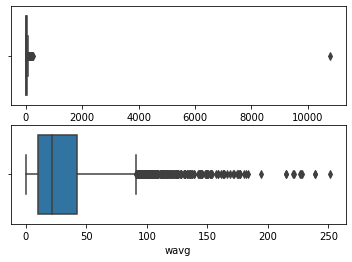

In [0]:
user_wavg_action_per_session = user_wavg_action_per_session.join(churn, user_wavg_action_per_session.userId == churn.userId)
a = user_wavg_action_per_session.filter(user_wavg_action_per_session['churn']==0).toPandas()a.
b = user_wavg_action_per_session.filter(user_wavg_action_per_session['churn']==1).toPandas()

f, axes = plt.subplots(2, 1)
ax1= sns.boxplot(x=a['wavg'], ax = axes[0])
ax2=sns.boxplot(x=b['wavg'], ax= axes[1])
plt.show()

In [0]:
a = a.loc[a['wavg']<2000]

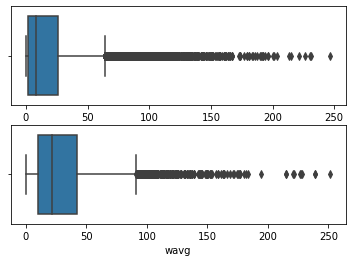

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

f, axes = plt.subplots(2, 1)
ax1= sns.boxplot(x=a['wavg'], ax = axes[0])
ax2=sns.boxplot(x=b['wavg'], ax= axes[1])
plt.show()

In [0]:
a

,userId,cancel_day,wavg,userId,churn,cancel_day
0,1000407,0,0.0,1000407,0,0
1,1000611,0,0.0,1000611,0,0
2,1000625,0,0.0,1000625,0,0
3,1001129,0,0.0,1001129,0,0
4,1001246,0,0.0,1001246,0,0
...,...,...,...,...,...,...
17270,1999455,0,0.0,1999455,0,0
17271,1999691,0,0.0,1999691,0,0
17272,1999848,0,0.0,1999848,0,0
17273,1999905,0,0.0,1999905,0,0
